/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


[-0.42789075  3.16929673]
[-0.42789075  3.16929673]
[-0.42789075  3.16929673]


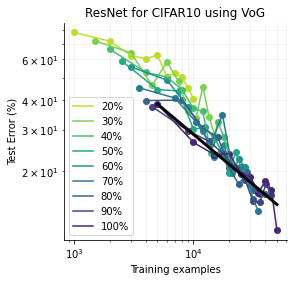

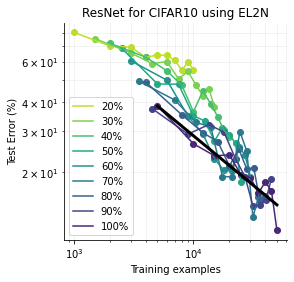

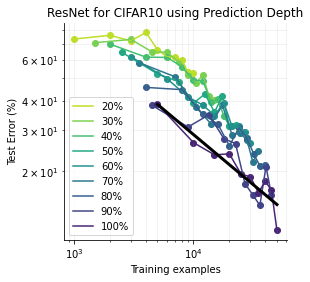

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np

for dataset in ['cifar10']:#, 'svhn']:
    for metric in ['vog', 'el2n', 'pd']:
        frac_list = list(range(20, 100, 10)) if dataset=='cifar10' else [60, 36, 22, 13, 8, 5, 3, 2, 1]
        dataset_size = 50000 if dataset=='cifar10' else 73257
        test_errors = {}
        for initial_size in [x/10 for x in range(1,11)]:
            frac = 100
            if frac not in test_errors:
                test_errors[frac] = {}
            test_errors[frac][initial_size] = 0
            count = 0
            for metric_alt in ['vog', 'el2n', 'pd']:
                filename = f'./results/errors_{dataset}_{metric_alt}_{initial_size}_{frac}.pkl'
                if os.path.exists(filename):
                    count += 1
                    with open(filename, 'rb') as f:
                        test_error, test_loss, training_loss = pickle.load(f)
                        test_errors[frac][initial_size] += test_error[199]
            test_errors[frac][initial_size] /= count
            for frac in frac_list:
                filename = f'./results/errors_{dataset}_{metric}_{initial_size}_{frac}.pkl'
                if os.path.exists(filename):
                    with open(filename, 'rb') as f:
                        test_error, test_loss, training_loss = pickle.load(f)
                        if frac not in test_errors:
                            test_errors[frac] = {}
                        test_errors[frac][initial_size] = test_error[199]#min(test_error.values())



        with sns.color_palette('viridis_r', len(test_errors)):
            plt.figure(figsize=(4,4))
            for frac in frac_list+[100]:
                if frac not in test_errors.keys():
                    continue
                training_examples = [frac*e*dataset_size/100 for e in test_errors[frac].keys()]
                errors = [e for e in test_errors[frac].values()]
                plt.scatter(training_examples,errors)
                plt.plot(training_examples,errors,label=str(int(np.round(frac)))+'%')
                if frac==100:
                    p = np.polyfit(np.log10(training_examples), np.log10(errors), 1)
                    print(p)
                    x = np.logspace(np.log10(min(training_examples)), np.log10(max(training_examples)), 100)
                    plt.plot(x, 10**np.polyval(p, np.log10(x)),'k',linewidth=3)
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('Test Error (%)')
        plt.xlabel('Training examples')
        plt.legend()
        # plt.xticks([1,2,3],[1,2,3])
        # plt.yticks([2,10,20,50],[2,10,20,50])
        # plt.ylim([10,100])
        # plt.xlim([1000, 500000])
        plt.grid(True,which='both',alpha=0.2)
        metric_name = {'vog':'VoG', 'el2n':'EL2N', 'pd':'Prediction Depth'}
        dataset_name = {'cifar10':'CIFAR10', 'svhn':'SVHN'}
        plt.title(f'ResNet for {dataset_name[dataset]} using {metric_name[metric]}')
        sns.despine()

In [4]:
import pandas as pd
df = pd.DataFrame()
metric_name = {'vog':'VoG', 'el2n':'EL2N', 'pd':'Prediction Depth'}
for metric in ['vog', 'el2n', 'pd']:
    filename = f'./results/metrics_cifar10_{metric}_1.0.pkl'
    with open(filename, 'rb') as f:
        indices, metrics = pickle.load(f)
        df[metric_name[metric]] = pd.Series(metrics.detach().cpu().numpy(), index=indices.detach().cpu().numpy())
df['Random'] = np.random.random(df.shape[0])

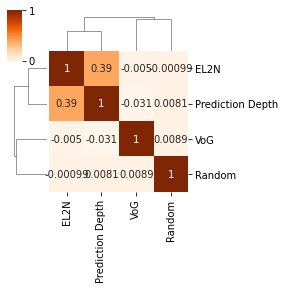

In [5]:
sns.clustermap(df.corr(method='spearman'), cmap="Oranges", annot=True, figsize=(4,4))

In [6]:
import pandas as pd
df = pd.DataFrame()
metric_name = {'vog':'VoG', 'el2n':'EL2N', 'pd':'Prediction Depth'}
metrics = ['vog', 'el2n', 'pd']
for metric in metrics:
    for frac in list(range(60, 110, 10)):
        filename = f'./results/errors_cifar10_{metric}_1.0_{frac}.pkl'
        with open(filename, 'rb') as f:
            test_error, test_loss, training_loss = pickle.load(f)
            df.loc[frac, metric_name[metric]] = 100 - test_error[199]
    
    for rand_frac in [x/10 for x in range(6,11)]:
        filename = f'./results/errors_cifar10_{metric}_{rand_frac}_100.pkl'
        with open(filename, 'rb') as f:
            test_error, test_loss, training_loss = pickle.load(f)
            df.loc[rand_frac*100, metric+'_rand'] = 100 - test_error[199]

random_cols = [metric+'_rand' for metric in metrics]
df['Random'] = df[random_cols].mean(axis=1)
df = df.drop(columns=random_cols)


acc_100 = df.loc[100,list(metric_name.values())].reset_index(drop=True).rename('No Pruning')
mean = df.loc[100, list(metric_name.values())].mean()
df.loc[100, list(metric_name.values())] = mean

In [7]:
df = df.reset_index().merge(acc_100, how='cross').set_index('index')

[Text(0.5, 0, 'Frac. data kept'), Text(0, 0.5, 'Accuracy (%)')]

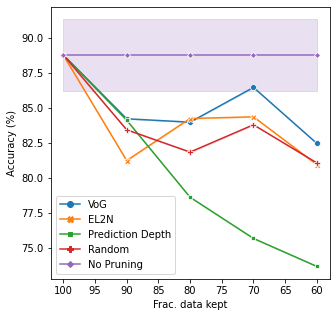

In [8]:
plt.figure(figsize=(5,5))
ax = sns.lineplot(df, markers=True, dashes=False, errorbar=('sd', 2), )
ax.invert_xaxis()
ax.set(xlabel='Frac. data kept', ylabel='Accuracy (%)')

In [2]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached numpy-1.24.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0a0 requires torch==1.11.0a0+17540c5, but you have torch 1.13.0 which is incompatible.
scipy 1.6.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
dask-cudf 21.12.0a0+293.g0930f712e6 requires pandas<1.4.0dev0,>=1.0, but you have pandas 1.5.2 which is incompatible.
cupy-cuda115 9.6.0 requires numpy<1.24,>=1.17, but you have numpy 1.24.2 which is incompatible.
cudf 21.12.0a0+293.g0930f712e6 requires pandas<1.4.0dev0,>=1.0, but you have pandas 1.5.2 which is incompatible.

